# Transfer learning Cat/Dog Classifier from MobileNetV2

Following the TF tutorial with my own dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2024-01-06 16:21:28.627236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 16:21:28.627282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 16:21:28.628319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-06 16:21:29.268893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data download

In [2]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
PATH = '/home/sam/datasets/dogs_cats/'

print(f'Dataset path: {PATH}')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            color_mode='rgb')

Dataset path: /home/sam/datasets/dogs_cats/
Found 1498 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 color_mode='rgb')

Found 200 files belonging to 2 classes.


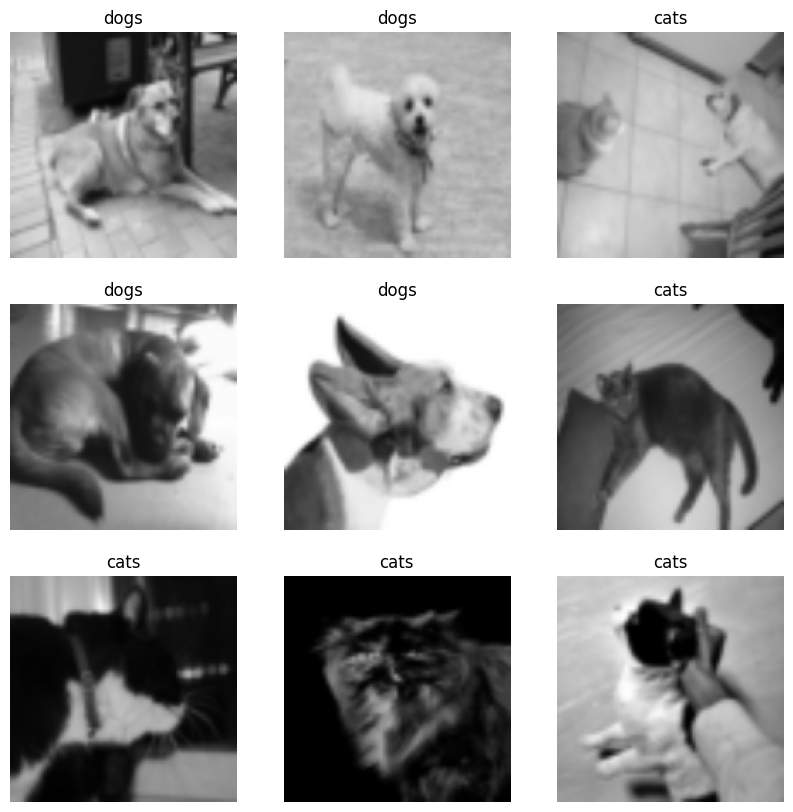

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

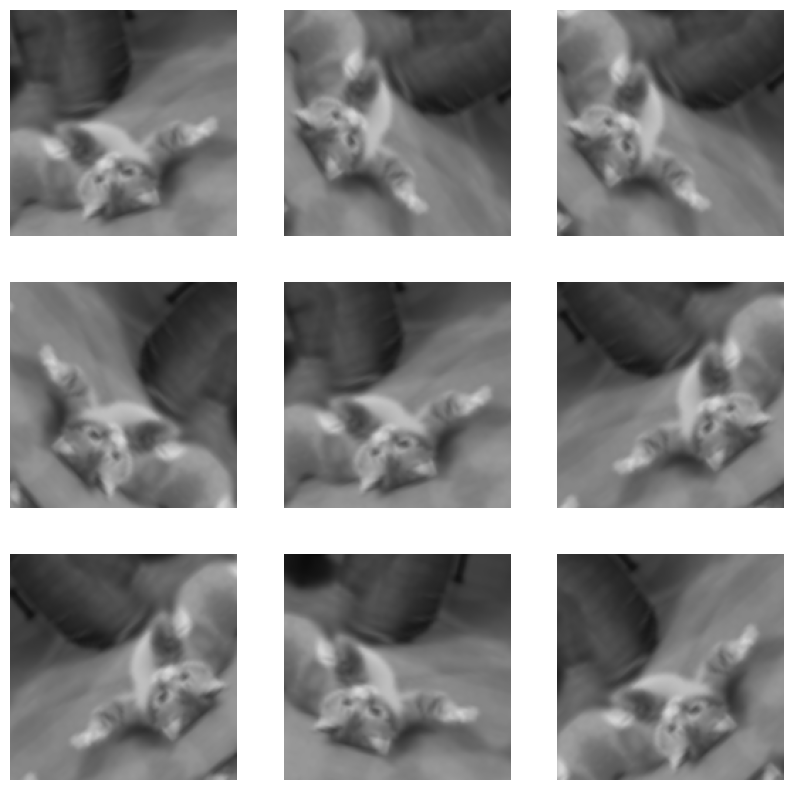

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(f'image_batch shape : {image_batch.shape}')
print(f'feature_batch shape : {feature_batch.shape}')

image_batch shape : (32, 160, 160, 3)
feature_batch shape : (32, 5, 5, 1280)


# Feature Extraction

In [14]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
print(f'Trainable variables: {len(model.trainable_variables)}')
model.summary()


Trainable variables: 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                      

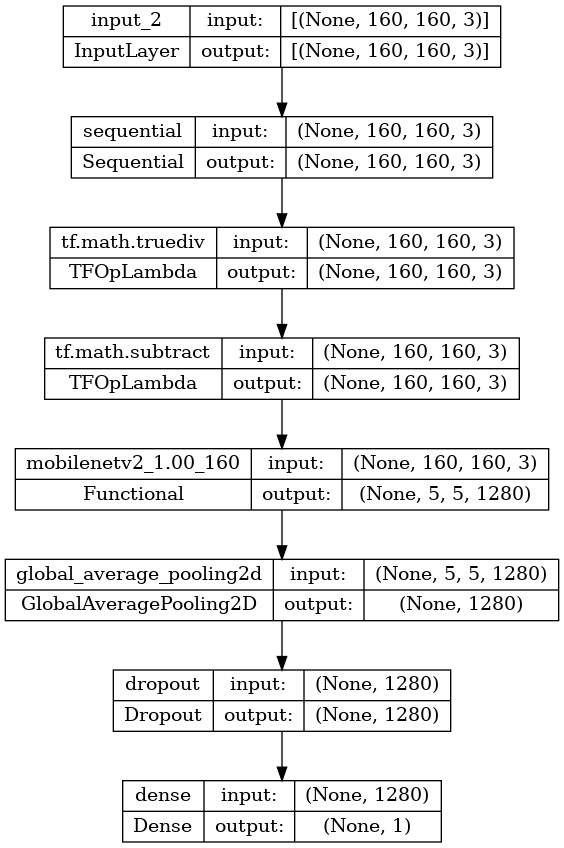

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Compile

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

# Train

In [21]:
loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 3s 203ms/step - loss: 0.9274 - accuracy: 0.5357


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.54


In [23]:
initial_epochs = 12
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/12
 2/47 [>.............................] - ETA: 2s - loss: 0.6652 - accuracy: 0.6562  

I0000 00:00:1704586901.428328  341648 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 5s 54ms/step - loss: 0.6966 - accuracy: 0.6515 - val_loss: 0.7564 - val_accuracy: 0.5536
Epoch 2/12
47/47 [==============================] - 1s 29ms/step - loss: 0.6664 - accuracy: 0.6495 - val_loss: 0.6983 - val_accuracy: 0.5714
Epoch 3/12
47/47 [==============================] - 1s 28ms/step - loss: 0.6425 - accuracy: 0.6602 - val_loss: 0.6651 - val_accuracy: 0.5952
Epoch 4/12
47/47 [==============================] - 1s 28ms/step - loss: 0.5950 - accuracy: 0.6956 - val_loss: 0.5932 - val_accuracy: 0.6667
Epoch 5/12
47/47 [==============================] - 1s 28ms/step - loss: 0.5758 - accuracy: 0.7063 - val_loss: 0.5736 - val_accuracy: 0.6964
Epoch 6/12
47/47 [==============================] - 1s 28ms/step - loss: 0.5689 - accuracy: 0.7123 - val_loss: 0.5755 - val_accuracy: 0.6726
Epoch 7/12
47/47 [==============================] - 1s 28ms/step - loss: 0.5417 - accuracy: 0.7256 - val_loss: 0.5399 - val_accuracy: 0.7083
Epoch 8/12
47/47 [======

# Learning curves

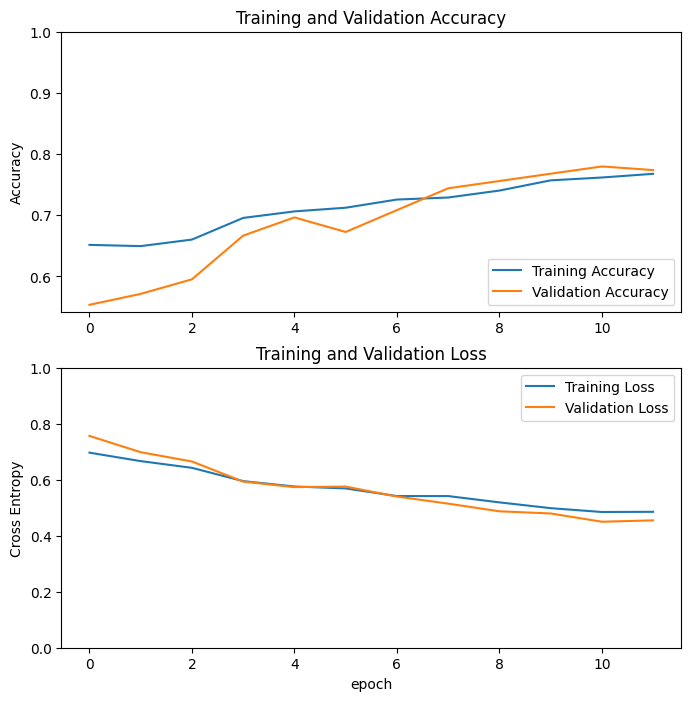

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0]
Labels:
 [1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0]


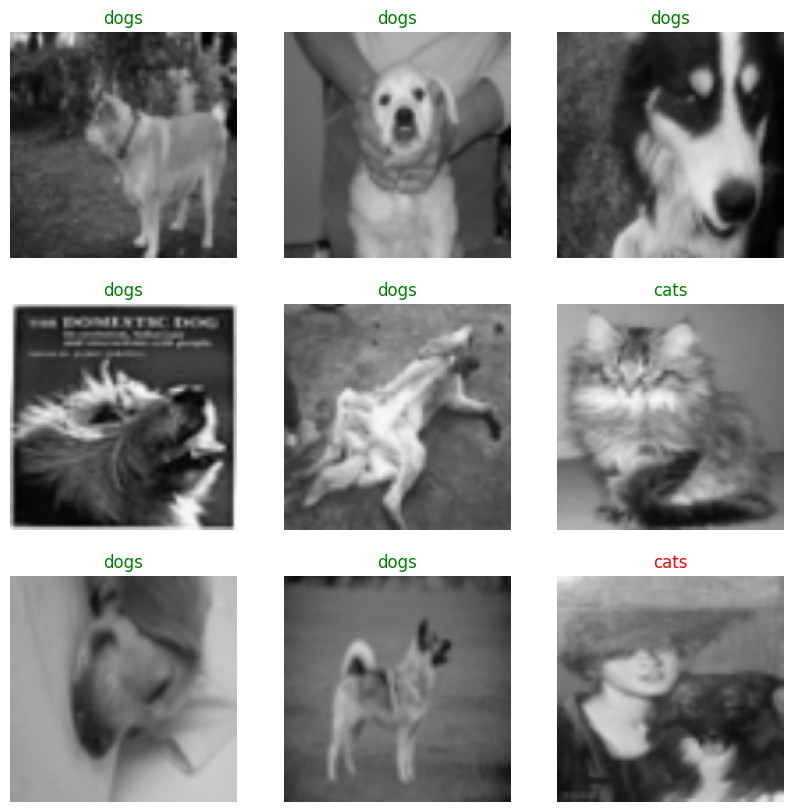

In [39]:
def visualize_on_test():
  # Retrieve a batch of images from the test set
  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', predictions.numpy())
  print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f'{class_names[predictions[i]]}', color="green" if (label_batch[i] == predictions[i]) else "red")
    plt.axis("off")
visualize_on_test()

# Fine tuning

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [30]:
len(model.trainable_variables)

56

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 12/22


47/47 [==============================] - 2s 37ms/step - loss: 0.2753 - accuracy: 0.8785 - val_loss: 0.3176 - val_accuracy: 0.8512
Epoch 13/22
47/47 [==============================] - 2s 38ms/step - loss: 0.2626 - accuracy: 0.8879 - val_loss: 0.3089 - val_accuracy: 0.8810
Epoch 14/22
47/47 [==============================] - 2s 40ms/step - loss: 0.2672 - accuracy: 0.8845 - val_loss: 0.2944 - val_accuracy: 0.8869
Epoch 15/22
47/47 [==============================] - 2s 40ms/step - loss: 0.2576 - accuracy: 0.8879 - val_loss: 0.3264 - val_accuracy: 0.8512
Epoch 16/22
47/47 [==============================] - 2s 40ms/step - loss: 0.2685 - accuracy: 0.8825 - val_loss: 0.2801 - val_accuracy: 0.8750
Epoch 17/22
47/47 [==============================] - 2s 41ms/step - loss: 0.2466 - accuracy: 0.8965 - val_loss: 0.2849 - val_accuracy: 0.8750
Epoch 18/22
47/47 [==============================] - 2s 41ms/step - loss: 0.2202 - accuracy: 0.9025 - val_loss: 0.2877 - val_accuracy: 0.8810
Epoch 19/22
47/47 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

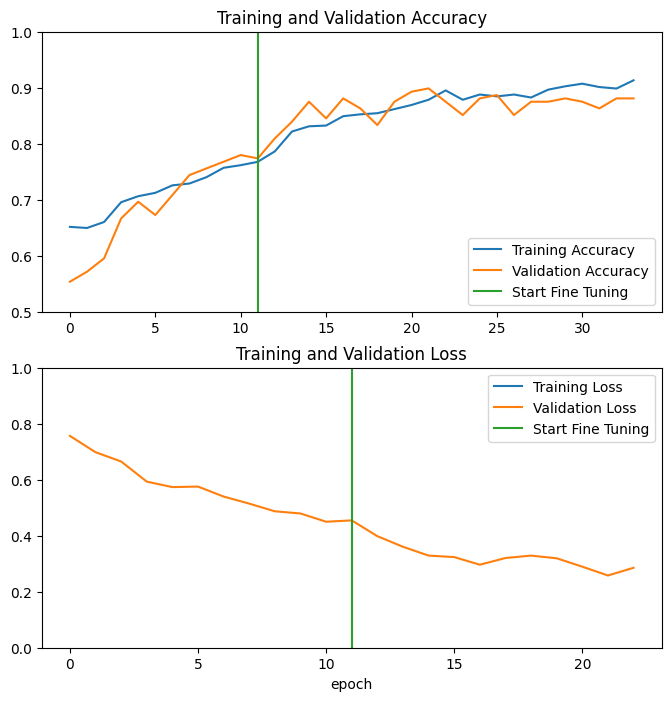

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 270ms/step - loss: 0.2577 - accuracy: 0.9375
Test accuracy : 0.9375


Predictions:
 [1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1]
Labels:
 [1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1]


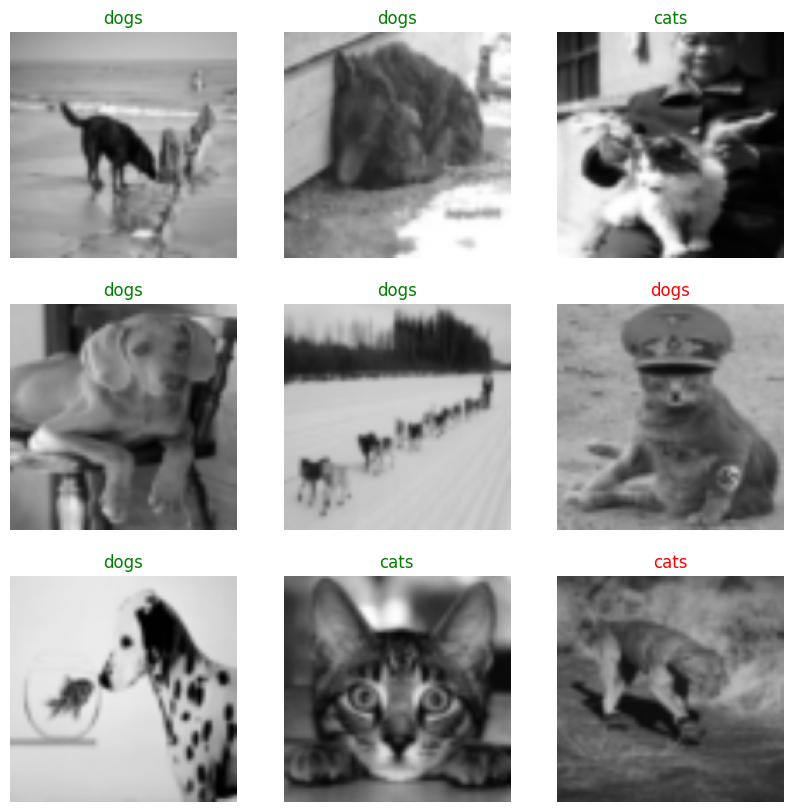

In [53]:
visualize_on_test()

In [54]:
print(image_batch.shape)
print(image_batch[0].min(), image_batch[0].max(), image_batch[0].mean())

(32, 160, 160, 3)
12.189999 224.51999 101.937256


# Test on single image

Predictions:
 [0]


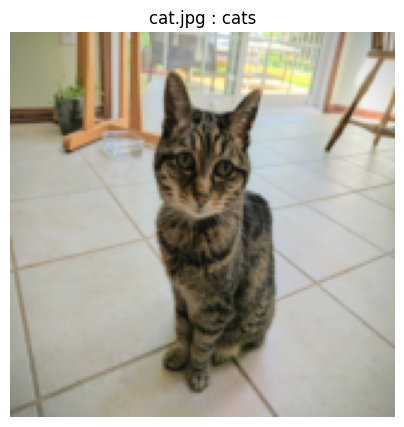

In [55]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# import PIL
def predictOnImage(img_path):
    # Retrieve a batch of images from the test set
    # img = PIL.Image.open(img_path)
    img_size = 160
    raw_img = load_img(img_path, target_size=(img_size, img_size), interpolation='bilinear')
    
    img = img_to_array(raw_img)
    image_batch = np.expand_dims(img, 0)
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Predictions:\n', predictions.numpy())

    plt.figure(figsize=(5, 5))
    plt.imshow(image_batch[0].astype("uint8"))
    plt.title(f'{img_path} : {class_names[predictions[0]]}')
    plt.axis("off")

predictOnImage('cat.jpg')

# Freeze model

In [56]:
model.save('dogcat_v1.keras')